# Coach Slide-Ready Workbook

This notebook is a consumer of Notebook 01 outputs.
It reads `outputs/results.json` and exported tables/figures without recomputing analysis.

## 0. Setup
- Run Notebook 01 first (or `scripts/render_visual_templates.py`).
- This notebook only formats text/tables and aliases figures for deck insertion.

In [1]:
import shutil

from pathlib import Path
import pandas as pd
from IPython.display import Image, Markdown, display

from browns_tracking.config import default_project_paths
from browns_tracking.pipeline import classify_hsr_exposure
from browns_tracking.presentation import (
    build_slide_1_snapshot_text,
    coach_early_late_table,
    coach_extrema_table,
    coach_peak_distance_table,
    coach_segment_table,
    coach_speed_band_table,
    write_slide_text,
)
from browns_tracking.results_contract import load_results_contract

pd.set_option('display.max_columns', 140)
pd.set_option('display.width', 240)

In [2]:
paths = default_project_paths()
OUTPUT_DIR = paths.output_dir
FIG_DIR = OUTPUT_DIR / 'figures'
TABLE_DIR = OUTPUT_DIR / 'tables'
TEXT_DIR = OUTPUT_DIR / 'slide_text'
TABLE_DIR.mkdir(parents=True, exist_ok=True)
TEXT_DIR.mkdir(parents=True, exist_ok=True)

contract = load_results_contract(OUTPUT_DIR)
session_summary = contract['session_summary']
qa_summary = contract['qa_summary']
validation_takeaways = contract.get('validation_takeaways', [])
thresholds = contract['thresholds']
hsr_threshold_mph = float(thresholds['hsr_threshold_mph'])
accel_threshold_ms2 = float(thresholds['accel_threshold_ms2'])
decel_threshold_ms2 = float(thresholds['decel_threshold_ms2'])

speed_band_summary = pd.read_csv(TABLE_DIR / 'absolute_speed_band_summary.csv')
distance_table = pd.read_csv(TABLE_DIR / 'peak_distance_windows.csv')
extrema = pd.read_csv(TABLE_DIR / 'session_extrema.csv')
event_counts = pd.read_csv(TABLE_DIR / 'session_event_counts.csv').iloc[0].to_dict()
early_late_summary = pd.read_csv(TABLE_DIR / 'early_vs_late_summary.csv')
coach_phase_summary = pd.read_csv(TABLE_DIR / 'coach_phase_summary.csv')
session_structure_map = pd.read_csv(TABLE_DIR / 'session_structure_map.csv')
validation_gates = pd.read_csv(TABLE_DIR / 'validation_gates.csv')
peak_windows = pd.read_csv(OUTPUT_DIR / 'peak_windows.csv')

required_figures = [
    FIG_DIR / '01_space.png',
    FIG_DIR / '02_time.png',
    FIG_DIR / '03_peaks.png',
    FIG_DIR / '04_structure.png',
]
missing_figures = [str(p) for p in required_figures if not p.exists()]
if missing_figures:
    raise FileNotFoundError(
        'Missing canonical figures. Run Notebook 01 or scripts/render_visual_templates.py first:\n'
        + '\n'.join(missing_figures)
    )

pd.Series({
    'Contract': str(OUTPUT_DIR / 'results.json'),
    'Model': contract['model']['name'],
    'Questions': '; '.join(contract['story_questions']),
}, name='value').to_frame()

,value
Contract,C:\docker_projects\browns_performance_science_...
Model,Balanced Football Session Model v1
Questions,Where did the player spend time (role/space)?;...


In [3]:
def show_saved_png(path, caption='', width=1250):
    png = Path(path)
    if caption:
        display(Markdown(f'**{caption}**'))
    if not png.exists():
        display(Markdown(f':warning: Missing `{png}`.'))
        return
    display(Image(filename=str(png), width=width))

## Deck Map (Use This 6-Slide Flow)

In [4]:
deck_outline = pd.DataFrame([
    {
        'slide': 1,
        'title': 'Session Snapshot + Validation Gates',
        'figure_or_table': (
            'outputs/tables/slide_1_data_quality_table.csv; '
            'outputs/tables/slide_1_validation_gates_table.csv'
        ),
        'one_line_takeaway': 'Data quality gates passed at a usable level, so workload outputs are decision-ready.'
    },
    {
        'slide': 2,
        'title': 'Where: Spatial Usage and Role Signature',
        'figure_or_table': (
            'outputs/figures/01_space.png; outputs/figures/04_structure.png; '
            'outputs/phase_table.csv; outputs/session_structure_map.csv'
        ),
        'one_line_takeaway': 'The session lived in specific field zones and repeated role-consistent movement patterns.'
    },
    {
        'slide': 3,
        'title': 'When: Intensity Timeline and Session Structure',
        'figure_or_table': 'outputs/figures/02_time.png; outputs/tables/slide_3_top_windows_table.csv',
        'one_line_takeaway': 'High-intensity work clustered in identifiable blocks rather than being evenly distributed.'
    },
    {
        'slide': 4,
        'title': 'What: Peak Demands and Repeatable Windows',
        'figure_or_table': (
            'outputs/figures/03_peaks.png; outputs/tables/slide_3_peak_distance_table.csv; '
            'outputs/tables/slide_3_event_counts_table.csv'
        ),
        'one_line_takeaway': 'Top windows define the true worst-case demands to anchor drill and conditioning targets.'
    },
    {
        'slide': 5,
        'title': 'Phase-Level Load Profile',
        'figure_or_table': 'outputs/tables/slide_4_segment_table.csv',
        'one_line_takeaway': 'Merged coach phases show which blocks carried most distance and high-speed stress.'
    },
    {
        'slide': 6,
        'title': 'Early vs Late Readiness Signal',
        'figure_or_table': 'outputs/tables/slide_5_early_late_table.csv',
        'one_line_takeaway': 'Late-session drift quantifies whether second-half output matched training intent.'
    },
])
display(deck_outline)
deck_outline.to_csv(TABLE_DIR / 'final_deck_outline.csv', index=False)

,slide,title,figure_or_table,one_line_takeaway
0,1,Session Snapshot + Validation Gates,outputs/tables/slide_1_data_quality_table.csv;...,"Data quality gates passed at a usable level, s..."
1,2,Where: Spatial Usage and Role Signature,outputs/figures/01_space.png; outputs/figures/...,The session lived in specific field zones and ...
2,3,When: Intensity Timeline and Session Structure,outputs/figures/02_time.png; outputs/tables/sl...,High-intensity work clustered in identifiable ...
3,4,What: Peak Demands and Repeatable Windows,outputs/figures/03_peaks.png; outputs/tables/s...,Top windows define the true worst-case demands...
4,5,Phase-Level Load Profile,outputs/tables/slide_4_segment_table.csv,Merged coach phases show which blocks carried ...
5,6,Early vs Late Readiness Signal,outputs/tables/slide_5_early_late_table.csv,Late-session drift quantifies whether second-h...


## Coach/Player Visual Report (Auto-Display)

**Slide 2 | Where: Spatial usage and role signature (density + key demand windows)**

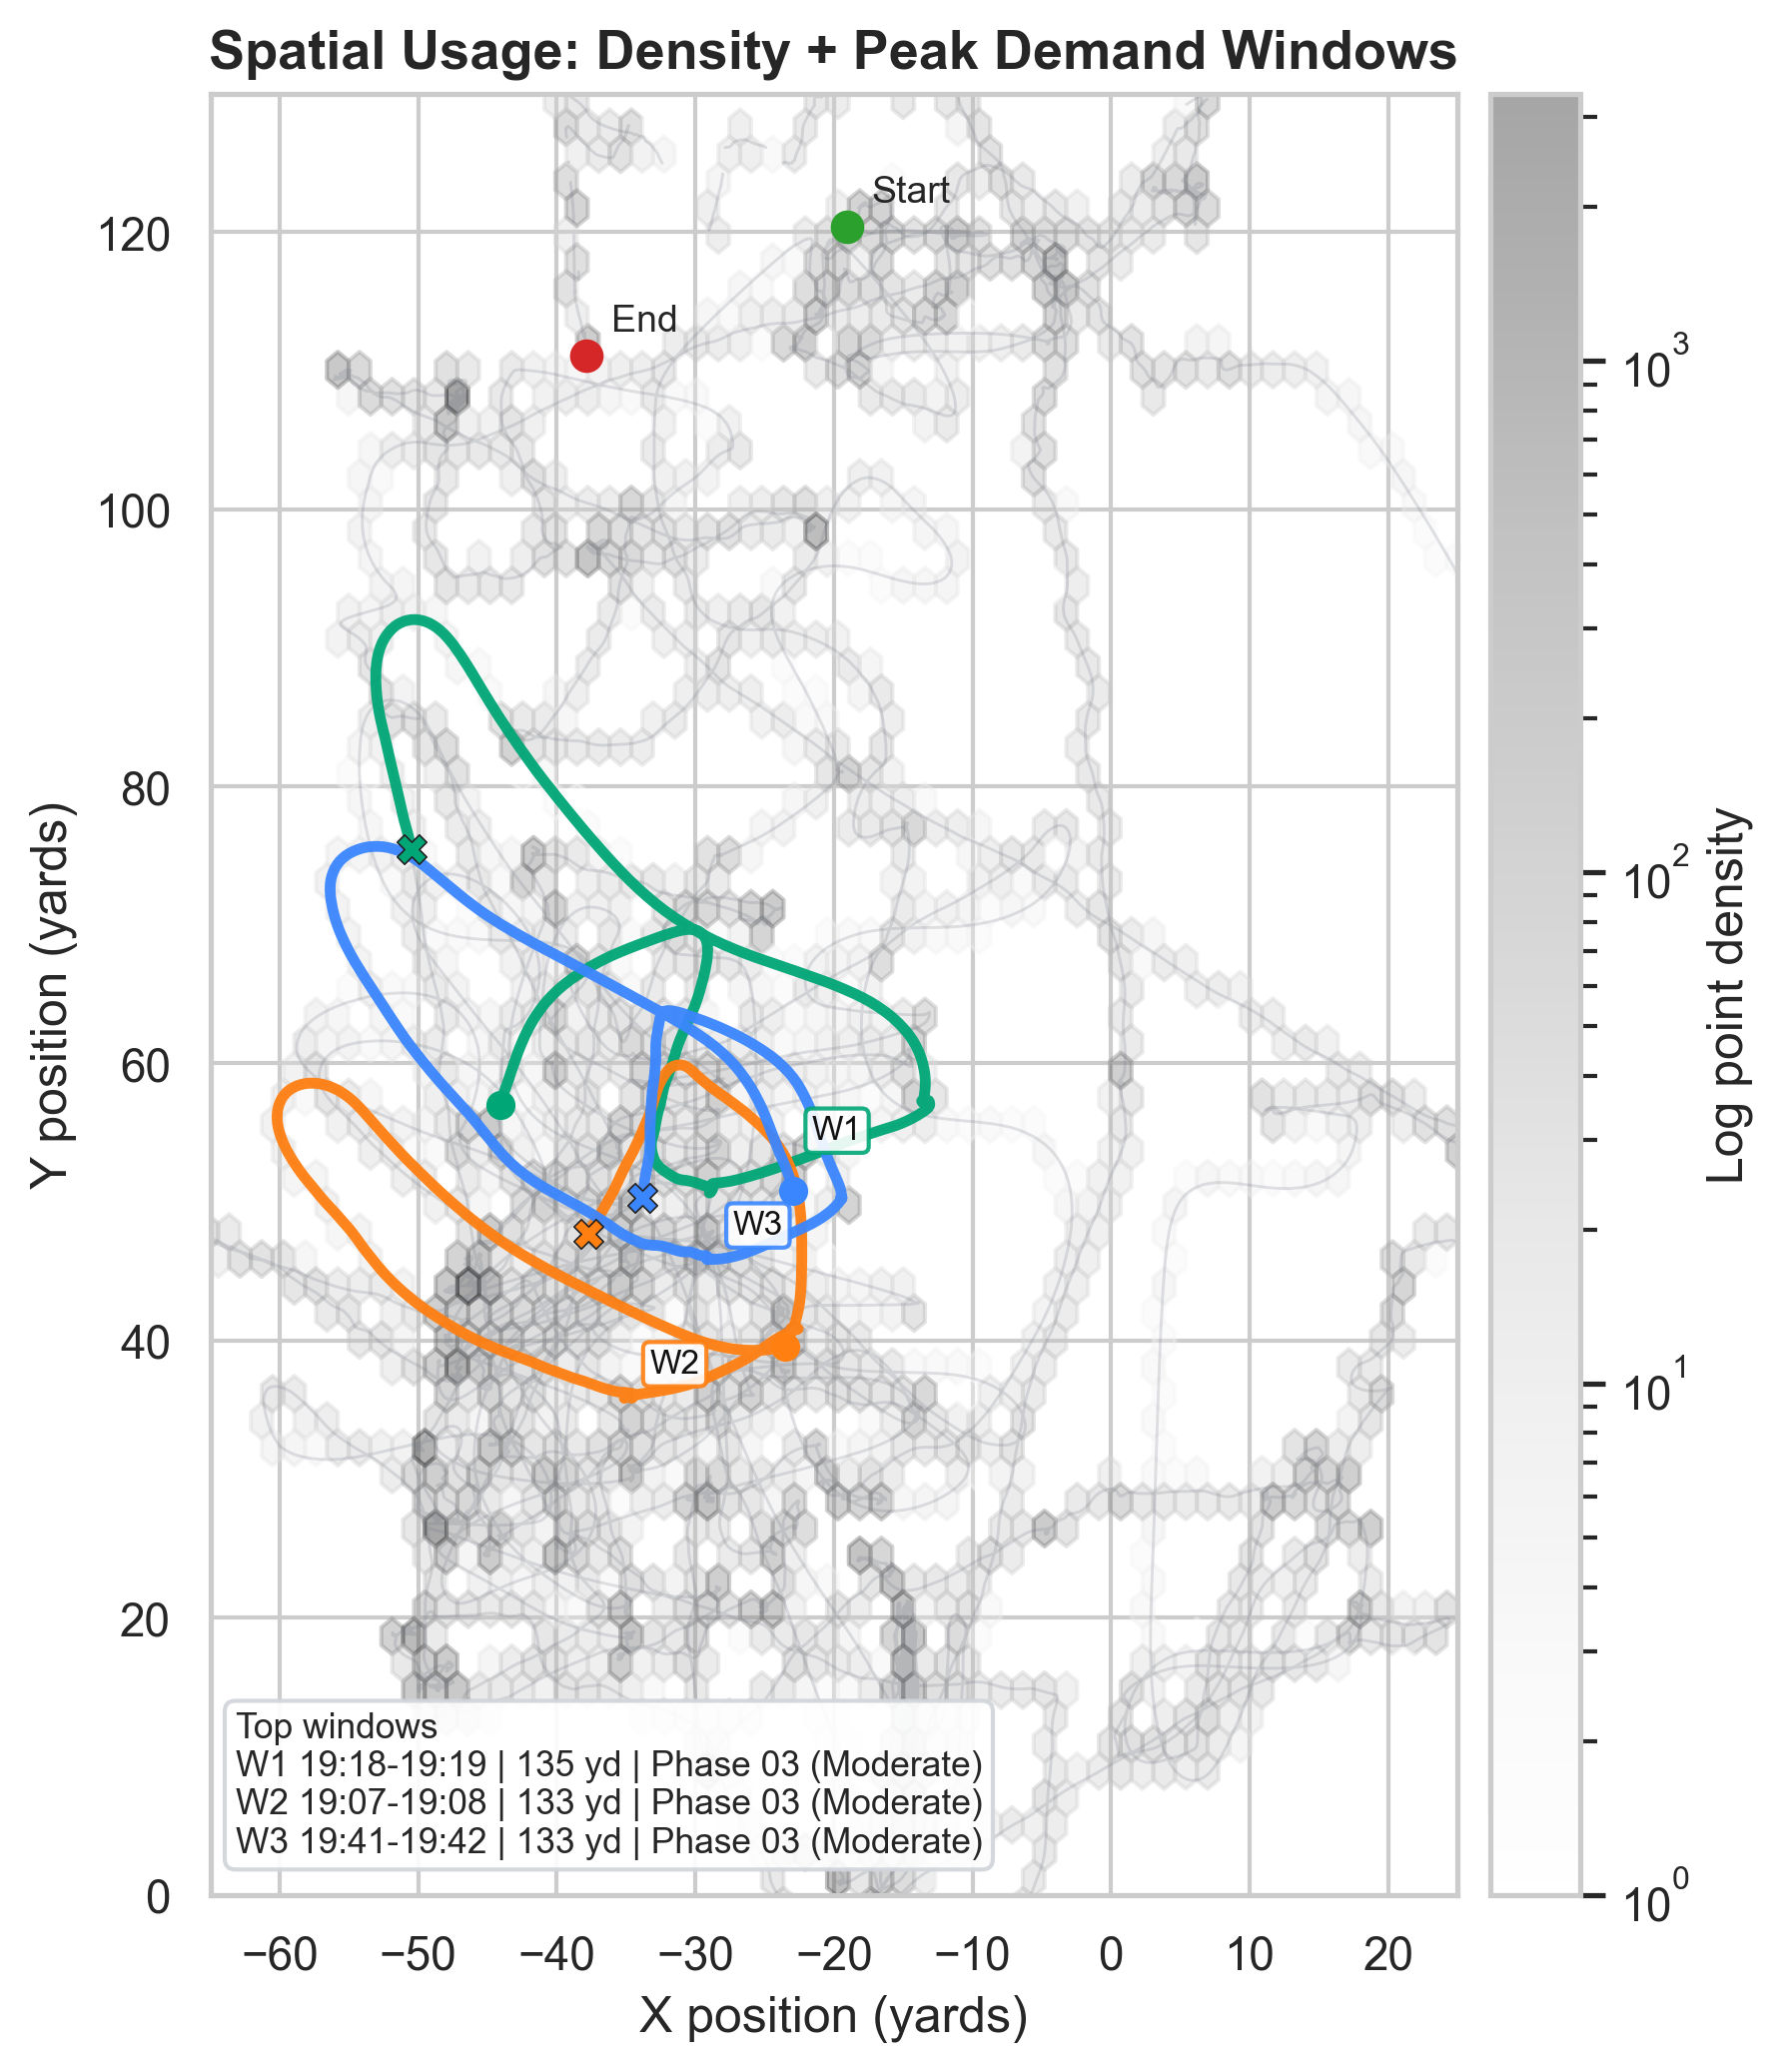

**Slide 3 | When: Intensity over time with phase strip, HSR events, and peak windows**

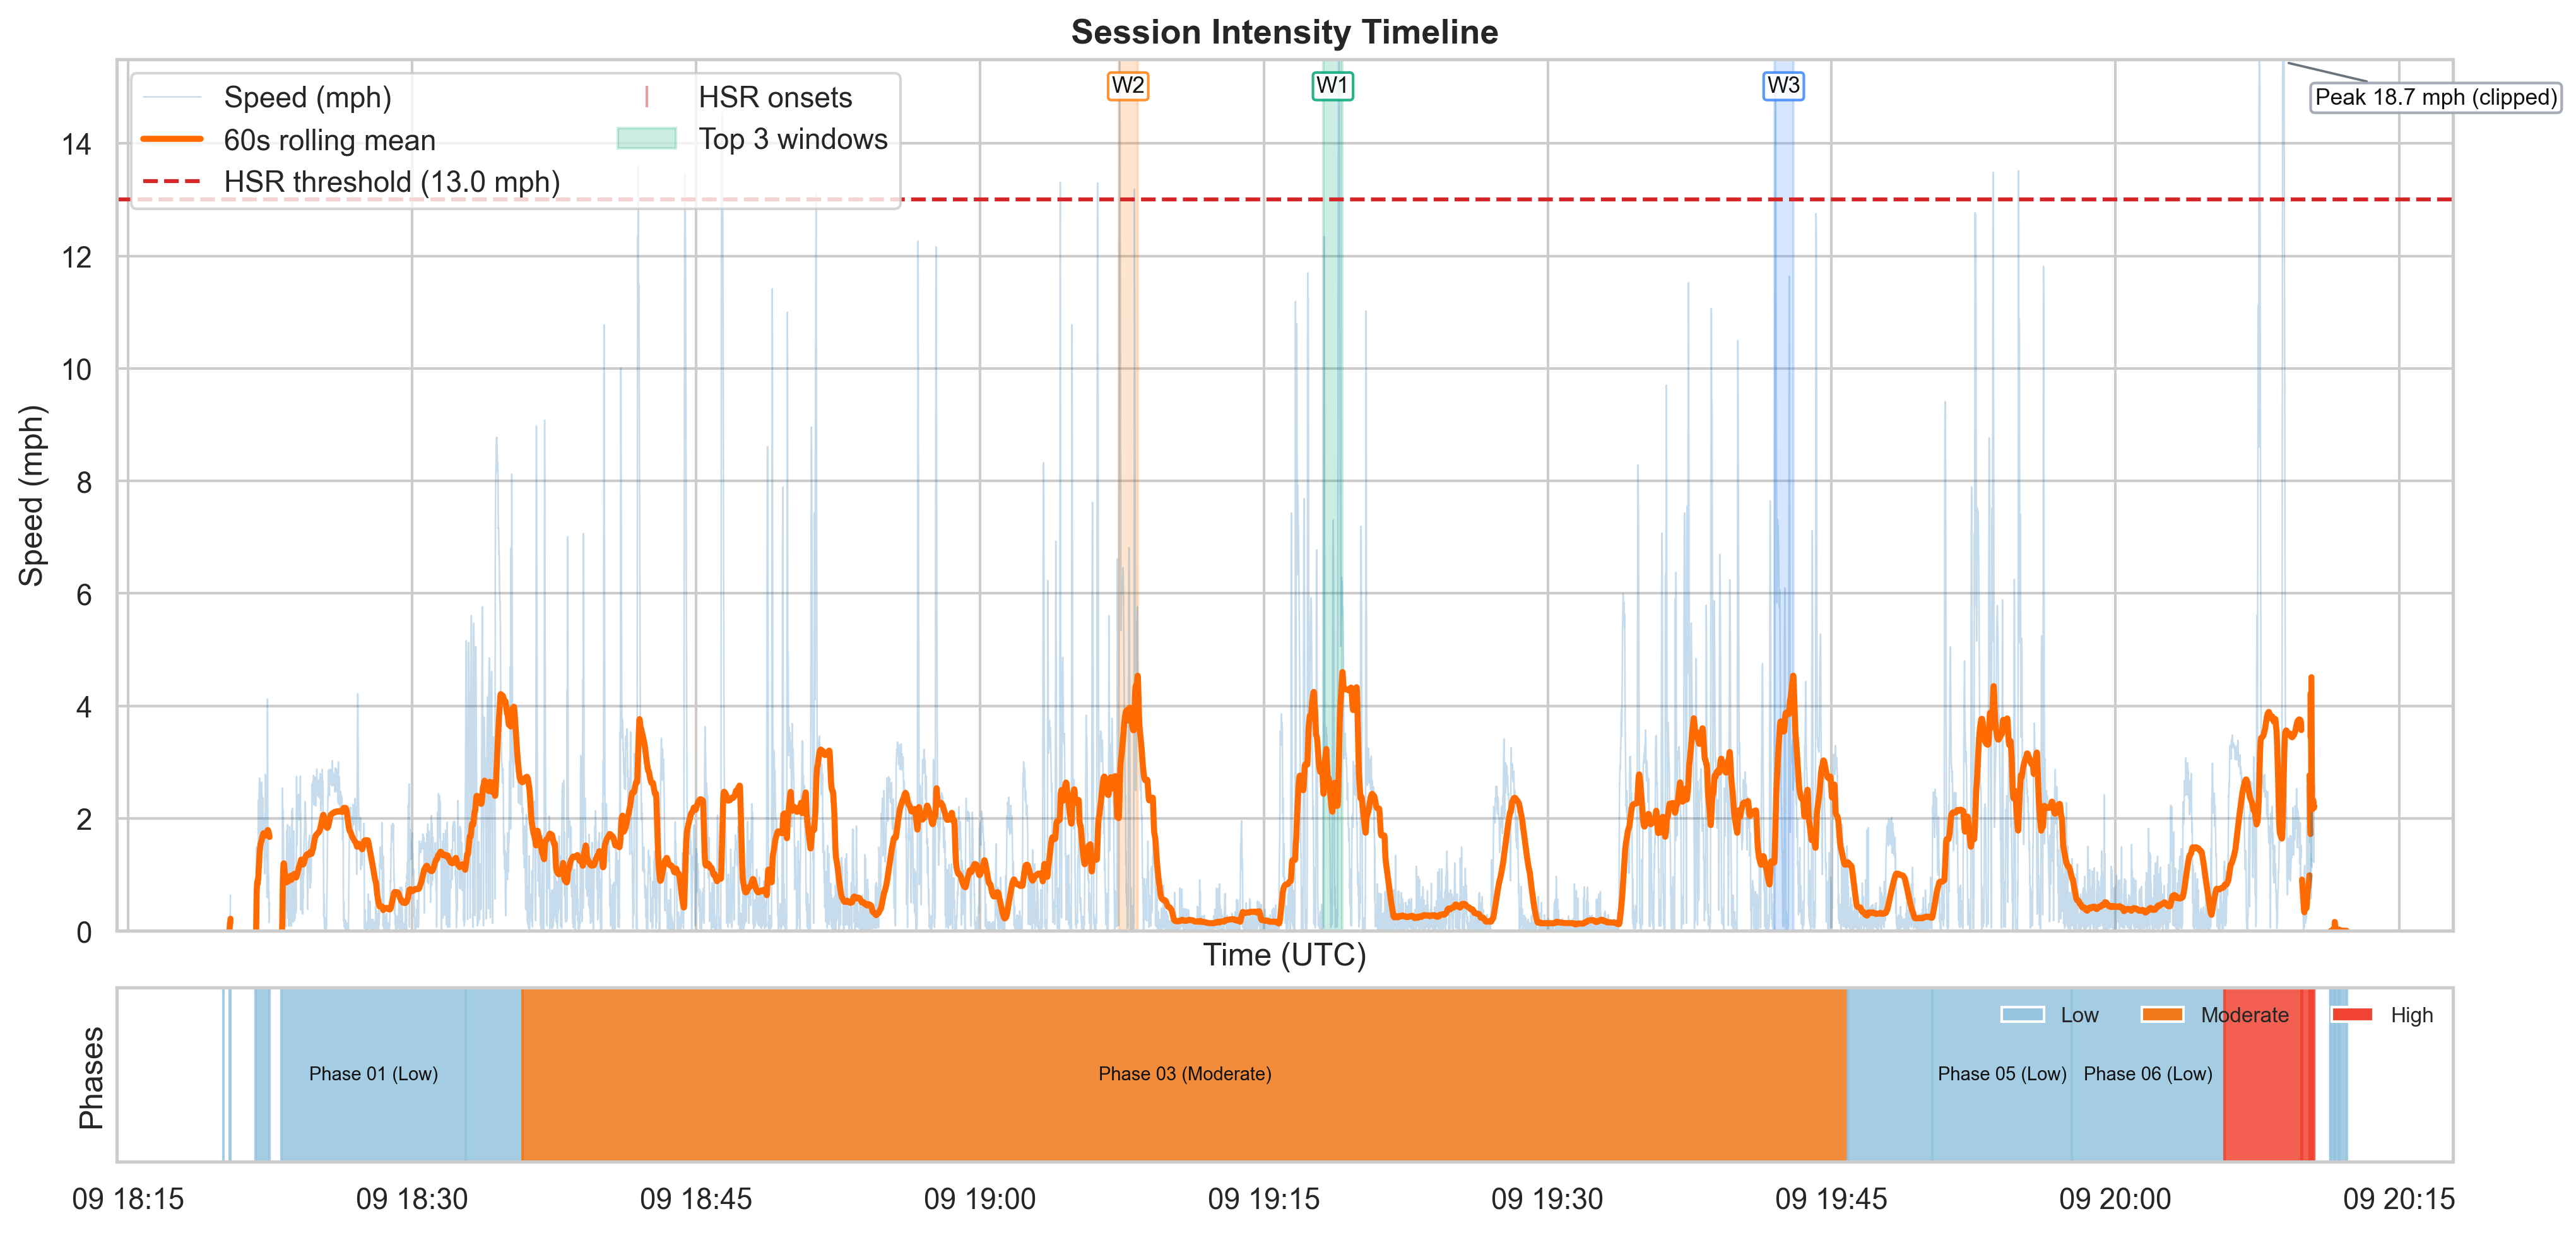

**Slide 4 | What: Peak demand windows and session maxima with event context**

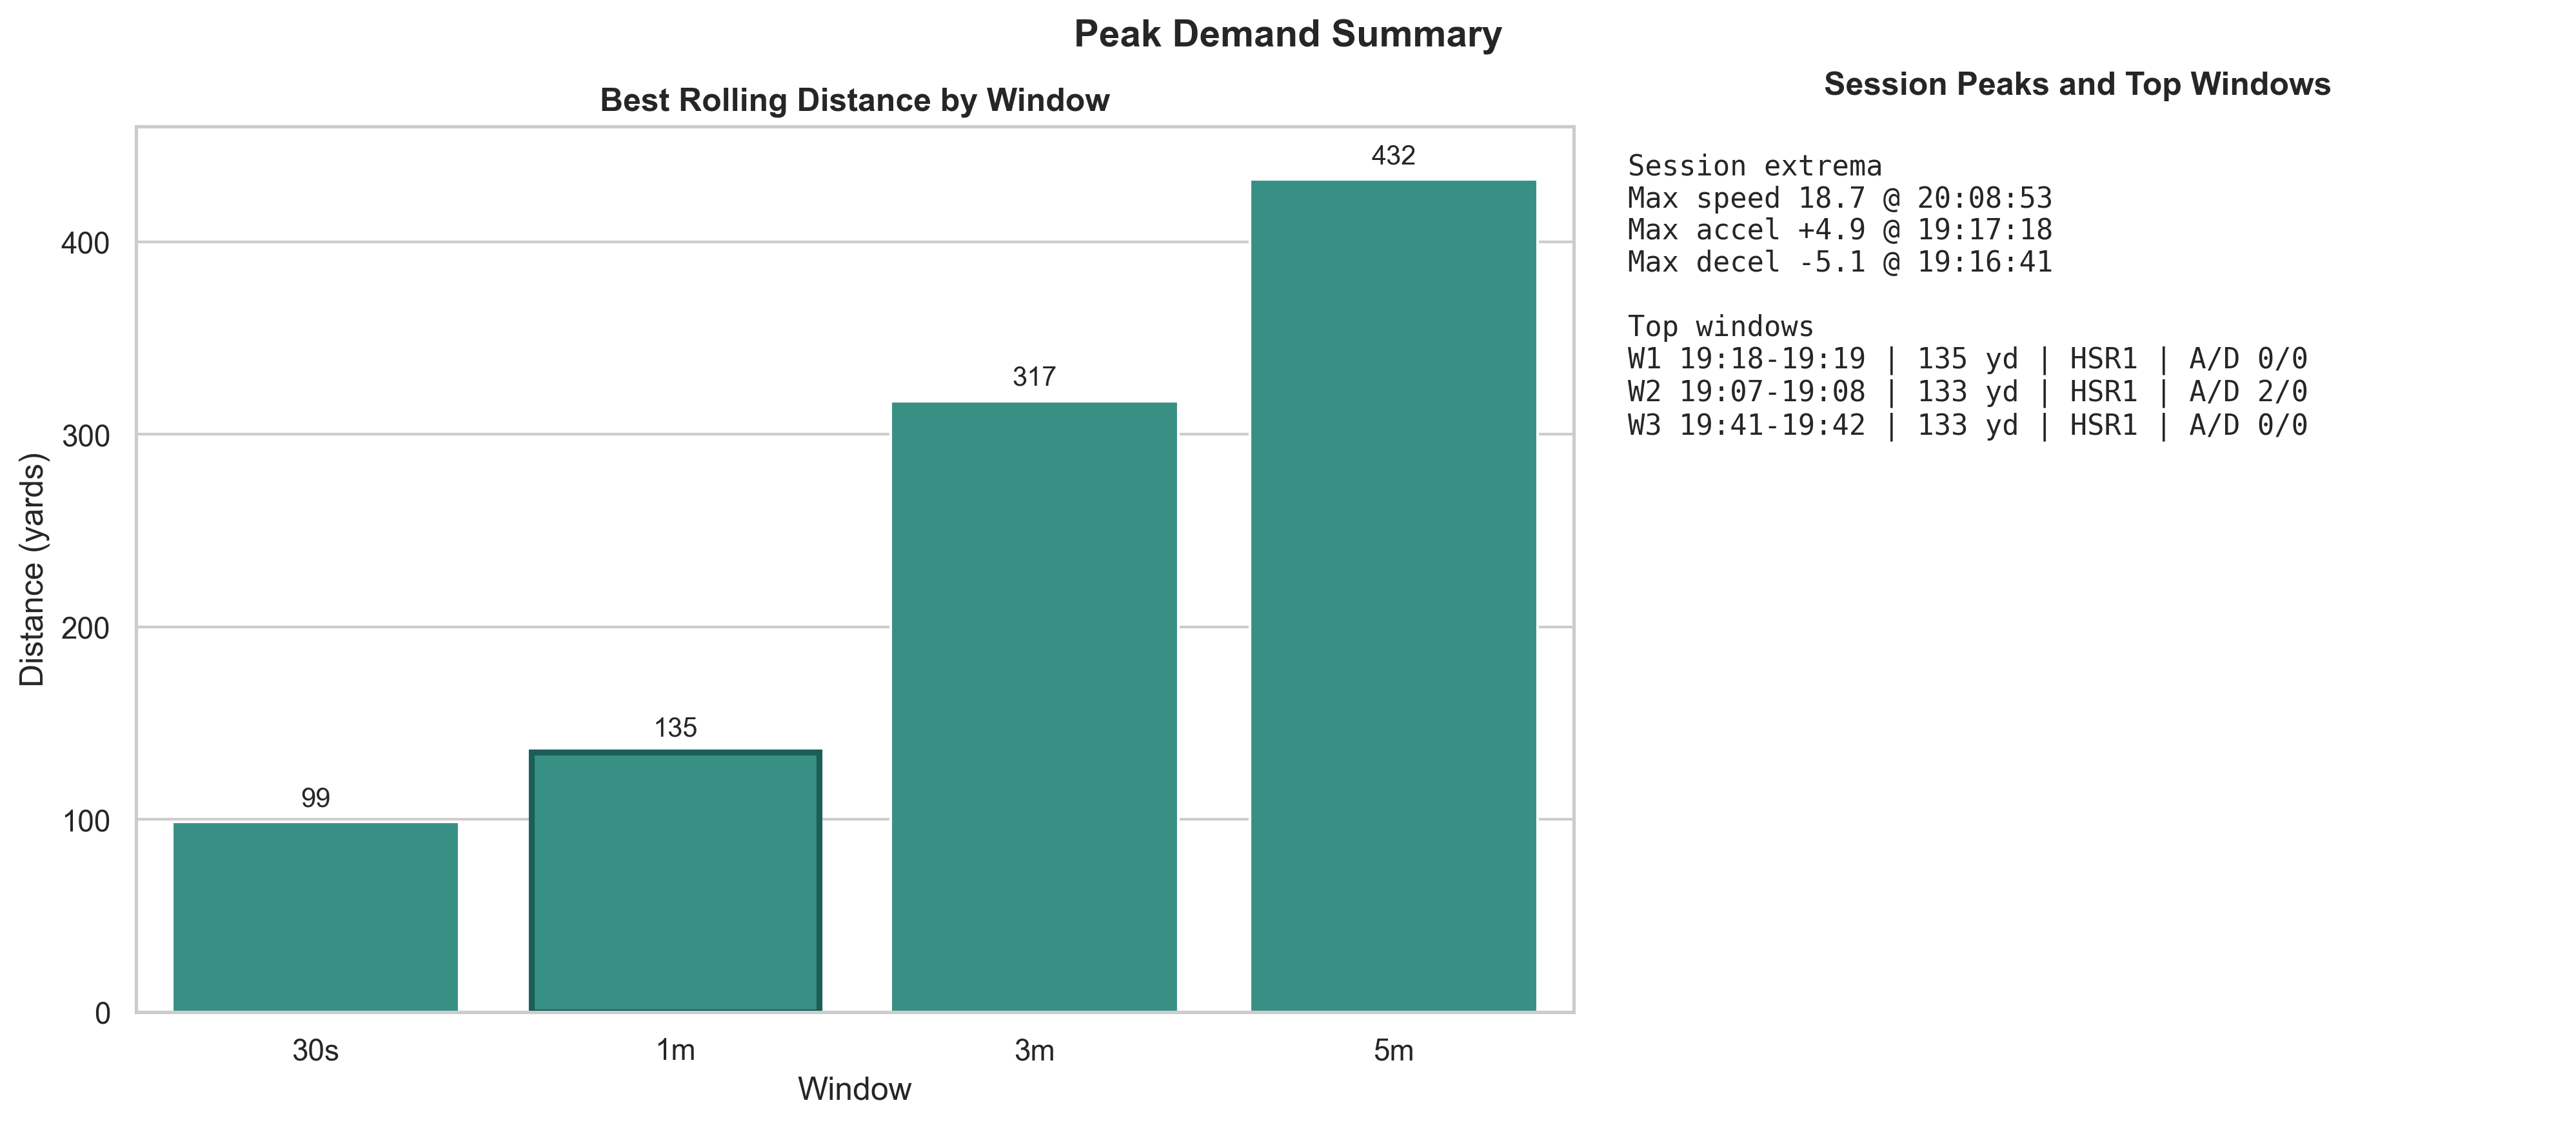

**Supplemental | Session structure map (phase drill taxonomy)**

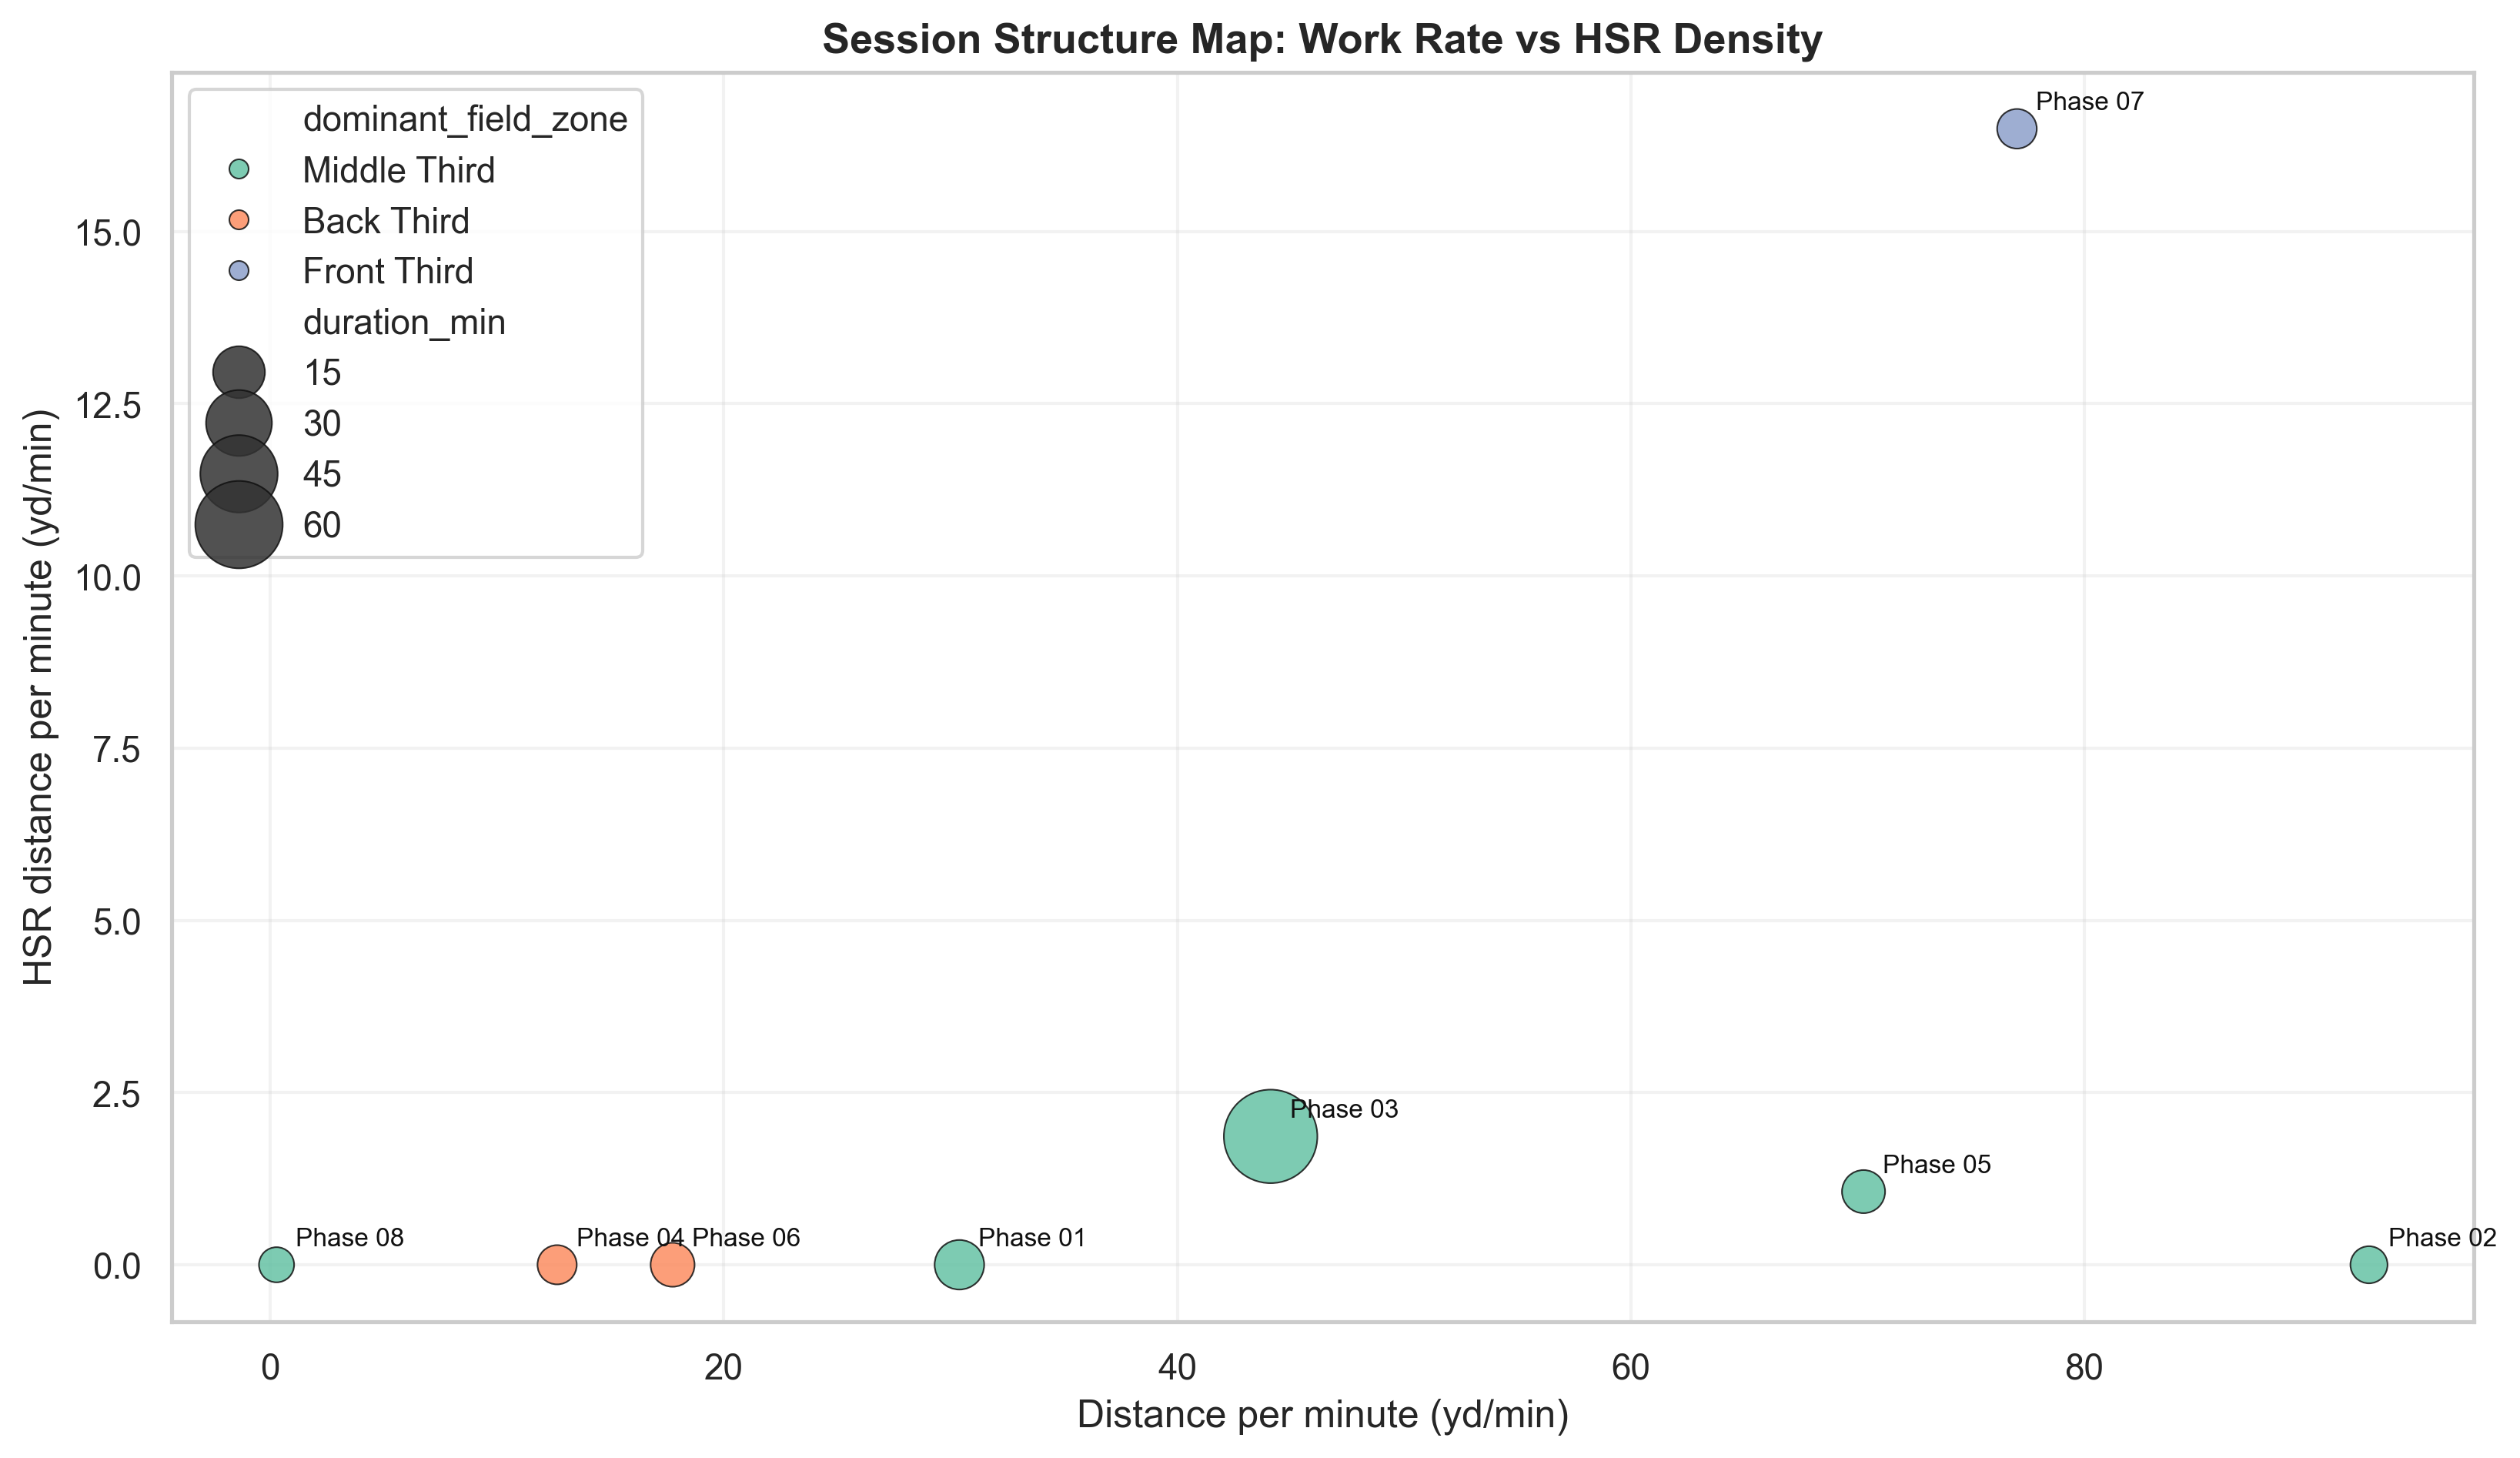

In [5]:
show_saved_png(
    FIG_DIR / '01_space.png',
    'Slide 2 | Where: Spatial usage and role signature (density + key demand windows)'
)
show_saved_png(
    FIG_DIR / '02_time.png',
    'Slide 3 | When: Intensity over time with phase strip, HSR events, and peak windows'
)
show_saved_png(
    FIG_DIR / '03_peaks.png',
    'Slide 4 | What: Peak demand windows and session maxima with event context'
)
show_saved_png(
    FIG_DIR / '04_structure.png',
    'Supplemental | Session structure map (phase drill taxonomy)'
)

## Coach/Player Summary Block

In [6]:
best_window = peak_windows.iloc[0] if not peak_windows.empty else None
coach_lines = [
    'Coach Lens',
    f"- Session phases: {len(coach_phase_summary)} merged blocks with clear intensity labels.",
    f"- Validation gates passed: {int((validation_gates['status'] == 'PASS').sum())}/{len(validation_gates)}.",
]
player_lines = [
    'Player Lens',
    f"- Peak speed: {float(session_summary['peak_speed_mph']):.2f} mph.",
    f"- HSR distance: {float(event_counts.get('hsr_distance_yd', 0.0)):.1f} yd.",
]
if best_window is not None:
    start = pd.Timestamp(best_window['window_start_utc']).strftime('%H:%M:%S')
    end = pd.Timestamp(best_window['window_end_utc']).strftime('%H:%M:%S')
    coach_lines.append(
        f"- Key drill anchor: best 1-min window {float(best_window['distance_yd']):.1f} yd ({start}-{end} UTC)."
    )
    player_lines.append(
        f"- Best 1-min work rate: {float(best_window['distance_yd']):.1f} yd; target repeat quality, not just volume."
    )
summary_md = '### ' + '\n'.join(coach_lines) + '\n\n### ' + '\n'.join(player_lines)
display(Markdown(summary_md))

### Coach Lens
- Session phases: 8 merged blocks with clear intensity labels.
- Validation gates passed: 4/5.
- Key drill anchor: best 1-min window 135.1 yd (19:18:09-19:19:09 UTC).

### Player Lens
- Peak speed: 18.71 mph.
- HSR distance: 216.7 yd.
- Best 1-min work rate: 135.1 yd; target repeat quality, not just volume.

## 1. Slide 1: Snapshot + Validation Gates

In [7]:
slide1_text = build_slide_1_snapshot_text(
    session_summary,
    hsr_threshold_mph=hsr_threshold_mph,
    event_summary=event_counts,
)
print(slide1_text)
write_slide_text(TEXT_DIR / 'slide_1_session_snapshot.txt', slide1_text)

qa_table = pd.DataFrame([qa_summary])[
    [
        'sample_count', 'expected_cadence_s', 'pct_on_expected_cadence',
        'max_gap_s', 'gap_count', 'gap_threshold_s',
        'step_distance_outlier_source',
        'step_distance_outlier_threshold_yd', 'step_distance_outlier_count',
        'step_distance_outlier_pct',
    ]
].rename(columns={
    'sample_count': 'Sample count',
    'expected_cadence_s': 'Expected cadence (s)',
    'pct_on_expected_cadence': '% at expected cadence',
    'max_gap_s': 'Max gap (s)',
    'gap_count': 'Gap count',
    'gap_threshold_s': 'Gap threshold (s)',
    'step_distance_outlier_source': 'Outlier source',
    'step_distance_outlier_threshold_yd': 'Outlier threshold (yd)',
    'step_distance_outlier_count': 'Outlier count',
    'step_distance_outlier_pct': 'Outlier count (%)',
})
for col, digits in [
    ('Expected cadence (s)', 3),
    ('% at expected cadence', 2),
    ('Max gap (s)', 2),
    ('Gap threshold (s)', 2),
    ('Outlier threshold (yd)', 2),
    ('Outlier count (%)', 2),
]:
    qa_table[col] = qa_table[col].round(digits)
display(qa_table)
qa_table.to_csv(TABLE_DIR / 'slide_1_data_quality_table.csv', index=False)

validation_table = validation_gates[['gate', 'status', 'value', 'threshold', 'direction', 'unit', 'notes']].copy()
validation_table.columns = ['Gate', 'Status', 'Value', 'Threshold', 'Direction', 'Unit', 'Notes']
validation_table['Value'] = pd.to_numeric(validation_table['Value'], errors='coerce').round(3)
display(validation_table)
validation_table.to_csv(TABLE_DIR / 'slide_1_validation_gates_table.csv', index=False)

pass_count = int((validation_gates['status'] == 'PASS').sum()) if not validation_gates.empty else 0
qa_text_lines = [
    'Data QA Summary',
    f"- {qa_table['% at expected cadence'].iloc[0]:.1f}% samples at 0.1s cadence.",
    f"- Max gap: {qa_table['Max gap (s)'].iloc[0]:.2f}s; gaps flagged above {qa_table['Gap threshold (s)'].iloc[0]:.2f}s.",
    f"- Outlier threshold: {qa_table['Outlier threshold (yd)'].iloc[0]:.2f} yd; flagged {int(qa_table['Outlier count'].iloc[0])} samples ({qa_table['Outlier count (%)'].iloc[0]:.2f}%).",
    f"- Validation gates passed: {pass_count}/{len(validation_gates)}.",
]
qa_text_lines.extend([f"- {line}" for line in validation_takeaways[:3]])
qa_text = '\n'.join(qa_text_lines)
print(qa_text)
write_slide_text(TEXT_DIR / 'slide_1_data_quality_takeaways.txt', qa_text)

Session Snapshot
- Duration: 112.2 min
- Total distance: 4,841 yd
- Mean speed: 1.51 mph
- Peak speed: 18.71 mph
- Peak accel/decel: 4.93 / -5.12 m/s^2
- HSR threshold for this report: 13.0 mph
- Sampling gaps (>0.15 s): 6
- HSR/Sprint events (>=1s): 6 / 4
- Accel/Decel events: 20 / 4


,Sample count,Expected cadence (s),% at expected cadence,Max gap (s),Gap count,Gap threshold (s),Outlier source,Outlier threshold (yd),Outlier count,Outlier count (%)
0,65410,0.1,99.99,80.3,6,0.15,step_distance_xy_yd,0.62,328,0.5


,Gate,Status,Value,Threshold,Direction,Unit,Notes
0,Cadence on target (%),PASS,99.991,95.0,>=,%,100.0% on-target cadence; gaps above 0.15s: 6 ...
1,Max time gap (s),WARN,80.300,0.5,<=,s,Max dt observed 80.30s (gate limit for pass 0....
2,Improbable position jump (%),PASS,0.011,0.5,<=,%,7 of 65410 samples imply XY speed > 14.0 yd/s.
3,Provided vs derived speed correlation,PASS,0.904,0.8,>=,r,Pearson correlation on 65410 aligned samples.
4,Provided vs derived speed outliers (%),PASS,0.070,3.0,<=,%,46 samples exceed |provided-derived| > 2.0 yd/s.


Data QA Summary
- 100.0% samples at 0.1s cadence.
- Max gap: 80.30s; gaps flagged above 0.15s.
- Outlier threshold: 0.62 yd; flagged 328 samples (0.50%).
- Validation gates passed: 4/5.
- Validation gates: 4/5 PASS.
- Trust policy: distance and workload totals are computed from speed channel (`s`).
- Coordinate jumps are low; movement map can be used for role/space interpretation.


## 2. Slide 2: Speed Zones

In [8]:
slide2_table = coach_speed_band_table(speed_band_summary)
display(slide2_table)
slide2_table.to_csv(TABLE_DIR / 'slide_2_speed_zone_table.csv', index=False)

top_zone = slide2_table.sort_values('Distance (yd)', ascending=False).iloc[0]
hsr_label = classify_hsr_exposure(
    total_distance_yd=float(session_summary['distance_yd_from_speed']),
    hsr_distance_yd=float(event_counts.get('hsr_distance_yd', 0.0)),
)
slide2_text = (
    'Speed Zone Takeaways\n'
    f"- Largest distance accumulation: {top_zone['Zone']} ({top_zone['Distance (%)']:.1f}% of total distance).\n"
    f"- HSR exposure classification: {hsr_label}.\n"
    '- Action: adjust high-speed volume by phase, not by session average only.'
)
print(slide2_text)
write_slide_text(TEXT_DIR / 'slide_2_speed_zone_takeaways.txt', slide2_text)

,Zone,Distance (yd),Distance (%),Time (s),Time (%),Mean speed (mph)
0,Walk,2486.1,51.4,5879.5,87.3,0.89
1,Cruise,1696.8,35.1,741.4,11.0,4.68
2,Run,441.1,9.1,82.9,1.2,10.88
3,HSR,132.2,2.7,19.2,0.3,14.09
4,Sprint,84.4,1.7,10.0,0.1,17.27


Speed Zone Takeaways
- Largest distance accumulation: Walk (51.4% of total distance).
- HSR exposure classification: Low.
- Action: adjust high-speed volume by phase, not by session average only.


## 3. Slide 3: Peak Demands

In [9]:
slide3_distance = coach_peak_distance_table(distance_table)
slide3_extrema = coach_extrema_table(extrema)
slide3_events = pd.DataFrame([
    {
        'HSR events (>=1s)': int(event_counts.get('hsr_event_count', 0)),
        'Sprint events (>=1s)': int(event_counts.get('sprint_event_count', 0)),
        'Accel events': int(event_counts.get('accel_event_count', 0)),
        'Decel events': int(event_counts.get('decel_event_count', 0)),
        'HSR distance (yd)': float(event_counts.get('hsr_distance_yd', 0.0)),
        'Sprint distance (yd)': float(event_counts.get('sprint_distance_yd', 0.0)),
    }
])
slide3_events['HSR distance (yd)'] = slide3_events['HSR distance (yd)'].round(1)
slide3_events['Sprint distance (yd)'] = slide3_events['Sprint distance (yd)'].round(1)

slide3_top_windows = peak_windows[
    ['window_rank', 'window_start_utc', 'window_end_utc', 'distance_yd', 'dominant_phase']
].copy().rename(columns={
    'window_rank': 'Window',
    'window_start_utc': 'Start (UTC)',
    'window_end_utc': 'End (UTC)',
    'distance_yd': 'Distance in window (yd)',
    'dominant_phase': 'Dominant phase',
})
slide3_top_windows['Start (UTC)'] = pd.to_datetime(
    slide3_top_windows['Start (UTC)'],
    utc=True,
    format='mixed',
).dt.strftime('%H:%M:%S')
slide3_top_windows['End (UTC)'] = pd.to_datetime(
    slide3_top_windows['End (UTC)'],
    utc=True,
    format='mixed',
).dt.strftime('%H:%M:%S')
slide3_top_windows['Distance in window (yd)'] = slide3_top_windows['Distance in window (yd)'].round(1)

display(slide3_distance)
display(slide3_extrema)
display(slide3_events)
display(slide3_top_windows)

slide3_distance.to_csv(TABLE_DIR / 'slide_3_peak_distance_table.csv', index=False)
slide3_extrema.to_csv(TABLE_DIR / 'slide_3_extrema_table.csv', index=False)
slide3_events.to_csv(TABLE_DIR / 'slide_3_event_counts_table.csv', index=False)
slide3_top_windows.to_csv(TABLE_DIR / 'slide_3_top_windows_table.csv', index=False)

if slide3_top_windows.empty:
    slide3_text = 'Peak Demand Takeaways\n- Not enough samples to derive stable top-demand windows.'
else:
    best = peak_windows.iloc[0]
    best_start = pd.Timestamp(best['window_start_utc']).strftime('%H:%M:%S')
    best_end = pd.Timestamp(best['window_end_utc']).strftime('%H:%M:%S')
    slide3_text = (
        'Peak Demand Takeaways\n'
        f"- Best 1-min demand: {float(best['distance_yd']):.1f} yd from {best_start} to {best_end} UTC.\n"
        f"- Context: HSR/Sprint {int(best['hsr_event_count'])}/{int(best['sprint_event_count'])}; Acc/Dec {int(best['accel_event_count'])}/{int(best['decel_event_count'])}.\n"
        f"- Dominant phase: {best['dominant_phase'] or 'N/A'}.\n"
        '- Action: use this window to set drill-level peak-demand targets.'
    )
print(slide3_text)
write_slide_text(TEXT_DIR / 'slide_3_peak_takeaways.txt', slide3_text)

,Window,Best distance (yd),Start (UTC),End (UTC)
0,30s,98.8,19:18:54,19:19:24
1,1m,135.1,19:18:09,19:19:09
2,3m,317.3,19:16:25,19:19:25
3,5m,432.4,19:15:50,19:20:50


,Metric,Value,Time (UTC)
0,Max speed (mph),18.71,20:08:53
1,Max accel (m/s^2),4.93,19:17:18
2,Max decel (m/s^2),-5.12,19:16:41


,HSR events (>=1s),Sprint events (>=1s),Accel events,Decel events,HSR distance (yd),Sprint distance (yd)
0,6,4,20,4,216.7,84.4


,Window,Start (UTC),End (UTC),Distance in window (yd),Dominant phase
0,1,19:18:09,19:19:09,135.1,Phase 03: Moderate Intensity
1,2,19:07:19,19:08:19,133.1,Phase 03: Moderate Intensity
2,3,19:41:58,19:42:58,133.1,Phase 03: Moderate Intensity


Peak Demand Takeaways
- Best 1-min demand: 135.1 yd from 19:18:09 to 19:19:09 UTC.
- Context: HSR/Sprint 1/1; Acc/Dec 0/0.
- Dominant phase: Phase 03: Moderate Intensity.
- Action: use this window to set drill-level peak-demand targets.


## 4. Slide 4: Session Phases

In [10]:
slide4_table = coach_segment_table(coach_phase_summary, top_n=8)
display(slide4_table)
slide4_table.to_csv(TABLE_DIR / 'slide_4_segment_table.csv', index=False)

top_phase = coach_phase_summary.sort_values('distance_yd', ascending=False).iloc[0]
high_phase_count = int((coach_phase_summary['intensity_level'] == 'High').sum())
slide4_text = (
    'Session Phase Takeaways\n'
    f"- Session merged into {len(coach_phase_summary)} coach-readable phases.\n"
    f"- Highest volume phase: {top_phase['coach_phase_label']} ({top_phase['distance_yd']:.1f} yd across {top_phase['duration_s'] / 60.0:.1f} min).\n"
    f"- High-intensity phases identified: {high_phase_count}.\n"
    '- Action: use phase boundaries as planning blocks for next session design.'
)
print(slide4_text)
write_slide_text(TEXT_DIR / 'slide_4_segment_takeaways.txt', slide4_text)

,Phase,Intensity,Duration (min),Distance (yd),HSR distance (yd),Accel events,Decel events,Mean speed (mph),Peak speed (mph),Peak 60s distance (yd)
0,Phase 03: Moderate Intensity,Moderate,70.04,3089.6,130.5,16,4,1.50,17.33,135.1
1,Phase 05: Low Intensity,Low,7.37,518.2,7.8,2,0,2.40,13.51,127.7
2,Phase 01: Low Intensity,Low,12.81,389.4,0.0,0,0,1.26,4.22,64.2
3,Phase 07: High Intensity,High,4.75,365.9,78.3,1,0,2.64,18.71,114.2
4,Phase 02: Low Intensity,Low,3.00,277.6,0.0,1,0,3.16,8.78,123.5
5,Phase 06: Low Intensity,Low,8.06,143.0,0.0,0,0,0.60,3.08,43.7
6,Phase 04: Low Intensity,Low,4.47,56.6,0.0,0,0,0.43,2.01,29.9
7,Phase 08: Low Intensity,Low,1.71,0.5,0.0,0,0,0.02,0.16,0.5


Session Phase Takeaways
- Session merged into 8 coach-readable phases.
- Highest volume phase: Phase 03: Moderate Intensity (3089.6 yd across 70.0 min).
- High-intensity phases identified: 1.
- Action: use phase boundaries as planning blocks for next session design.


## 5. Slide 5: Early vs Late

In [11]:
slide5_table = coach_early_late_table(early_late_summary)
display(slide5_table)
slide5_table.to_csv(TABLE_DIR / 'slide_5_early_late_table.csv', index=False)

if len(slide5_table) == 2:
    late = slide5_table.loc[slide5_table['Period'] == 'Late Half'].iloc[0]
    slide5_text = (
        'Early vs Late Takeaways\n'
        f"- Late-half distance vs early-half: {late['Distance vs early (%)']:+.1f}%.\n"
        f"- Late-half HSR/Sprint events: {int(late['HSR events'])}/{int(late['Sprint events'])}.\n"
        f"- Late-half accel/decel events: {int(late['Accel events'])}/{int(late['Decel events'])}.\n"
        '- Action: adjust second-half progression if high-speed or braking load drifts from intent.'
    )
else:
    slide5_text = 'Early vs Late Takeaways\n- Insufficient data for split-half comparison.'
print(slide5_text)
write_slide_text(TEXT_DIR / 'slide_5_early_late_takeaways.txt', slide5_text)

,Period,Duration (min),Distance (yd),Distance vs early (%),Mean speed (mph),Peak speed (mph),HSR distance (yd),Sprint distance (yd),HSR events,Sprint events,Accel events,Decel events
0,Early Half,56.11,2335.0,0.0,1.48,17.12,72.2,12.3,2,1,14,3
1,Late Half,56.11,2505.8,7.3,1.55,18.71,144.5,72.2,4,3,6,1


Early vs Late Takeaways
- Late-half distance vs early-half: +7.3%.
- Late-half HSR/Sprint events: 4/3.
- Late-half accel/decel events: 6/1.
- Action: adjust second-half progression if high-speed or braking load drifts from intent.


## 6. Figure Aliases for Slide Deck

In [12]:
figure_aliases = {
    '01_space.png': 'coach_slide_movement_map.png',
    '02_time.png': 'coach_slide_intensity_timeline.png',
    '03_peaks.png': 'coach_slide_peak_demand_summary.png',
    '04_structure.png': 'coach_slide_session_structure_map.png',
}
for src, dst in figure_aliases.items():
    source = FIG_DIR / src
    if not source.exists():
        raise FileNotFoundError(f'Missing {source}. Run Notebook 01 first.')
    shutil.copyfile(source, FIG_DIR / dst)

('Saved aliases', FIG_DIR / 'coach_slide_movement_map.png', FIG_DIR / 'coach_slide_intensity_timeline.png', FIG_DIR / 'coach_slide_peak_demand_summary.png')

('Saved aliases',
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_movement_map.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_intensity_timeline.png'),
 WindowsPath('C:/docker_projects/browns_performance_science_fellowship/outputs/figures/coach_slide_peak_demand_summary.png'))